# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Get the data from UCI dataset
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URL)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [5]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [6]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 912us/sample - loss: 235.4782 - y1_output_loss: 116.2335 - y2_output_loss: 117.0412 - y1_output_root_mean_squared_error: 10.8329 - y2_output_root_mean_squared_error: 10.8686 - val_loss: 30.9573 - val_y1_output_loss: 10.8146 - val_y2_output_loss: 19.0843 - val_y1_output_root_mean_squared_error: 3.3471 - val_y2_output_root_mean_squared_error: 4.4446
Epoch 2/500
614/614 [==============================] - 0s 144us/sample - loss: 42.2547 - y1_output_loss: 15.2147 - y2_output_loss: 26.9702 - y1_output_root_mean_squared_error: 3.9140 - y2_output_root_mean_squared_error: 5.1899 - val_loss: 29.5242 - val_y1_output_loss: 9.8980 - val_y2_output_loss: 18.5549 - val_y1_output_root_mean_squared_error: 3.2042 - val_y2_output_root_mean_squared_error: 4.3883
Epoch 3/500
614/614 [==============================] - 0s 135us/sample - loss: 29.8227 - y1_output_loss: 10.6094 - y2_output_loss: 19.0571 - y1_

614/614 [==============================] - 0s 135us/sample - loss: 15.9682 - y1_output_loss: 5.8061 - y2_output_loss: 10.1833 - y1_output_root_mean_squared_error: 2.4150 - y2_output_root_mean_squared_error: 3.1837 - val_loss: 21.5515 - val_y1_output_loss: 5.1782 - val_y2_output_loss: 16.0944 - val_y1_output_root_mean_squared_error: 2.3137 - val_y2_output_root_mean_squared_error: 4.0247
Epoch 22/500
614/614 [==============================] - 0s 139us/sample - loss: 15.2977 - y1_output_loss: 5.5383 - y2_output_loss: 9.7384 - y1_output_root_mean_squared_error: 2.3607 - y2_output_root_mean_squared_error: 3.1185 - val_loss: 35.5653 - val_y1_output_loss: 7.0523 - val_y2_output_loss: 28.3070 - val_y1_output_root_mean_squared_error: 2.6887 - val_y2_output_root_mean_squared_error: 5.3232
Epoch 23/500
614/614 [==============================] - 0s 136us/sample - loss: 14.1302 - y1_output_loss: 5.2641 - y2_output_loss: 8.8950 - y1_output_root_mean_squared_error: 2.2860 - y2_output_root_mean_square

614/614 [==============================] - 0s 141us/sample - loss: 8.9058 - y1_output_loss: 2.9013 - y2_output_loss: 5.9889 - y1_output_root_mean_squared_error: 1.7087 - y2_output_root_mean_squared_error: 2.4466 - val_loss: 10.3766 - val_y1_output_loss: 3.1801 - val_y2_output_loss: 7.1995 - val_y1_output_root_mean_squared_error: 1.7930 - val_y2_output_root_mean_squared_error: 2.6761
Epoch 42/500
614/614 [==============================] - 0s 139us/sample - loss: 8.7457 - y1_output_loss: 2.8204 - y2_output_loss: 5.9653 - y1_output_root_mean_squared_error: 1.6781 - y2_output_root_mean_squared_error: 2.4351 - val_loss: 8.3343 - val_y1_output_loss: 2.8796 - val_y2_output_loss: 5.1885 - val_y1_output_root_mean_squared_error: 1.7261 - val_y2_output_root_mean_squared_error: 2.3140
Epoch 43/500
614/614 [==============================] - 0s 133us/sample - loss: 7.8888 - y1_output_loss: 2.5224 - y2_output_loss: 5.3433 - y1_output_root_mean_squared_error: 1.5848 - y2_output_root_mean_squared_error

Epoch 62/500
614/614 [==============================] - 0s 136us/sample - loss: 5.8516 - y1_output_loss: 1.5600 - y2_output_loss: 4.2628 - y1_output_root_mean_squared_error: 1.2518 - y2_output_root_mean_squared_error: 2.0700 - val_loss: 10.0886 - val_y1_output_loss: 2.9495 - val_y2_output_loss: 6.7753 - val_y1_output_root_mean_squared_error: 1.7485 - val_y2_output_root_mean_squared_error: 2.6517
Epoch 63/500
614/614 [==============================] - 0s 143us/sample - loss: 6.9783 - y1_output_loss: 2.0558 - y2_output_loss: 4.9203 - y1_output_root_mean_squared_error: 1.4387 - y2_output_root_mean_squared_error: 2.2155 - val_loss: 4.3552 - val_y1_output_loss: 1.0353 - val_y2_output_loss: 3.3122 - val_y1_output_root_mean_squared_error: 1.0189 - val_y2_output_root_mean_squared_error: 1.8213
Epoch 64/500
614/614 [==============================] - 0s 142us/sample - loss: 5.6060 - y1_output_loss: 1.5860 - y2_output_loss: 3.9902 - y1_output_root_mean_squared_error: 1.2608 - y2_output_root_mean_

Epoch 83/500
614/614 [==============================] - 0s 131us/sample - loss: 7.2698 - y1_output_loss: 1.8342 - y2_output_loss: 5.3883 - y1_output_root_mean_squared_error: 1.3606 - y2_output_root_mean_squared_error: 2.3278 - val_loss: 2.7146 - val_y1_output_loss: 0.4937 - val_y2_output_loss: 2.1583 - val_y1_output_root_mean_squared_error: 0.7124 - val_y2_output_root_mean_squared_error: 1.4856
Epoch 84/500
614/614 [==============================] - 0s 134us/sample - loss: 3.6921 - y1_output_loss: 0.7276 - y2_output_loss: 2.9356 - y1_output_root_mean_squared_error: 0.8566 - y2_output_root_mean_squared_error: 1.7200 - val_loss: 2.8346 - val_y1_output_loss: 0.5689 - val_y2_output_loss: 2.1934 - val_y1_output_root_mean_squared_error: 0.7588 - val_y2_output_root_mean_squared_error: 1.5029
Epoch 85/500
614/614 [==============================] - 0s 133us/sample - loss: 3.8025 - y1_output_loss: 0.8842 - y2_output_loss: 2.9027 - y1_output_root_mean_squared_error: 0.9418 - y2_output_root_mean_s

Epoch 104/500
614/614 [==============================] - 0s 131us/sample - loss: 4.7432 - y1_output_loss: 1.2540 - y2_output_loss: 3.5024 - y1_output_root_mean_squared_error: 1.1237 - y2_output_root_mean_squared_error: 1.8656 - val_loss: 2.7392 - val_y1_output_loss: 0.6663 - val_y2_output_loss: 1.9875 - val_y1_output_root_mean_squared_error: 0.8264 - val_y2_output_root_mean_squared_error: 1.4340
Epoch 105/500
614/614 [==============================] - 0s 141us/sample - loss: 3.1447 - y1_output_loss: 0.7327 - y2_output_loss: 2.3892 - y1_output_root_mean_squared_error: 0.8575 - y2_output_root_mean_squared_error: 1.5523 - val_loss: 2.2195 - val_y1_output_loss: 0.3641 - val_y2_output_loss: 1.7971 - val_y1_output_root_mean_squared_error: 0.6105 - val_y2_output_root_mean_squared_error: 1.3590
Epoch 106/500
614/614 [==============================] - 0s 129us/sample - loss: 3.1352 - y1_output_loss: 0.6375 - y2_output_loss: 2.4776 - y1_output_root_mean_squared_error: 0.8012 - y2_output_root_mea

614/614 [==============================] - 0s 134us/sample - loss: 2.7395 - y1_output_loss: 0.5634 - y2_output_loss: 2.2076 - y1_output_root_mean_squared_error: 0.7537 - y2_output_root_mean_squared_error: 1.4736 - val_loss: 2.6645 - val_y1_output_loss: 0.3812 - val_y2_output_loss: 2.2315 - val_y1_output_root_mean_squared_error: 0.6242 - val_y2_output_root_mean_squared_error: 1.5082
Epoch 125/500
614/614 [==============================] - 0s 124us/sample - loss: 2.5460 - y1_output_loss: 0.5449 - y2_output_loss: 2.0040 - y1_output_root_mean_squared_error: 0.7384 - y2_output_root_mean_squared_error: 1.4145 - val_loss: 1.8744 - val_y1_output_loss: 0.3439 - val_y2_output_loss: 1.4772 - val_y1_output_root_mean_squared_error: 0.5949 - val_y2_output_root_mean_squared_error: 1.2331
Epoch 126/500
614/614 [==============================] - 0s 128us/sample - loss: 2.5355 - y1_output_loss: 0.5333 - y2_output_loss: 2.0097 - y1_output_root_mean_squared_error: 0.7302 - y2_output_root_mean_squared_erro

Epoch 145/500
614/614 [==============================] - 0s 143us/sample - loss: 3.3095 - y1_output_loss: 0.8761 - y2_output_loss: 2.4021 - y1_output_root_mean_squared_error: 0.9404 - y2_output_root_mean_squared_error: 1.5573 - val_loss: 1.5773 - val_y1_output_loss: 0.2592 - val_y2_output_loss: 1.2660 - val_y1_output_root_mean_squared_error: 0.5160 - val_y2_output_root_mean_squared_error: 1.1450
Epoch 146/500
614/614 [==============================] - 0s 130us/sample - loss: 1.8155 - y1_output_loss: 0.3621 - y2_output_loss: 1.4560 - y1_output_root_mean_squared_error: 0.6018 - y2_output_root_mean_squared_error: 1.2056 - val_loss: 3.1623 - val_y1_output_loss: 0.5038 - val_y2_output_loss: 2.5812 - val_y1_output_root_mean_squared_error: 0.7223 - val_y2_output_root_mean_squared_error: 1.6250
Epoch 147/500
614/614 [==============================] - 0s 140us/sample - loss: 2.9976 - y1_output_loss: 0.7662 - y2_output_loss: 2.2274 - y1_output_root_mean_squared_error: 0.8789 - y2_output_root_mea

614/614 [==============================] - 0s 128us/sample - loss: 2.0642 - y1_output_loss: 0.4131 - y2_output_loss: 1.6520 - y1_output_root_mean_squared_error: 0.6426 - y2_output_root_mean_squared_error: 1.2850 - val_loss: 1.4205 - val_y1_output_loss: 0.3066 - val_y2_output_loss: 1.0804 - val_y1_output_root_mean_squared_error: 0.5608 - val_y2_output_root_mean_squared_error: 1.0517
Epoch 166/500
614/614 [==============================] - 0s 138us/sample - loss: 1.7082 - y1_output_loss: 0.3137 - y2_output_loss: 1.3881 - y1_output_root_mean_squared_error: 0.5623 - y2_output_root_mean_squared_error: 1.1798 - val_loss: 1.6947 - val_y1_output_loss: 0.2784 - val_y2_output_loss: 1.3866 - val_y1_output_root_mean_squared_error: 0.5332 - val_y2_output_root_mean_squared_error: 1.1876
Epoch 167/500
614/614 [==============================] - 0s 147us/sample - loss: 1.8277 - y1_output_loss: 0.3547 - y2_output_loss: 1.4837 - y1_output_root_mean_squared_error: 0.5962 - y2_output_root_mean_squared_erro

Epoch 186/500
614/614 [==============================] - 0s 132us/sample - loss: 1.5663 - y1_output_loss: 0.3290 - y2_output_loss: 1.2274 - y1_output_root_mean_squared_error: 0.5757 - y2_output_root_mean_squared_error: 1.1112 - val_loss: 1.8228 - val_y1_output_loss: 0.2653 - val_y2_output_loss: 1.5151 - val_y1_output_root_mean_squared_error: 0.5193 - val_y2_output_root_mean_squared_error: 1.2462
Epoch 187/500
614/614 [==============================] - 0s 136us/sample - loss: 1.5785 - y1_output_loss: 0.3278 - y2_output_loss: 1.2673 - y1_output_root_mean_squared_error: 0.5679 - y2_output_root_mean_squared_error: 1.1207 - val_loss: 1.3717 - val_y1_output_loss: 0.2616 - val_y2_output_loss: 1.0817 - val_y1_output_root_mean_squared_error: 0.5091 - val_y2_output_root_mean_squared_error: 1.0548
Epoch 188/500
614/614 [==============================] - 0s 129us/sample - loss: 1.3137 - y1_output_loss: 0.2894 - y2_output_loss: 1.0167 - y1_output_root_mean_squared_error: 0.5386 - y2_output_root_mea

614/614 [==============================] - 0s 141us/sample - loss: 1.4314 - y1_output_loss: 0.2609 - y2_output_loss: 1.1672 - y1_output_root_mean_squared_error: 0.5123 - y2_output_root_mean_squared_error: 1.0812 - val_loss: 1.6755 - val_y1_output_loss: 0.1601 - val_y2_output_loss: 1.4882 - val_y1_output_root_mean_squared_error: 0.3984 - val_y2_output_root_mean_squared_error: 1.2316
Epoch 207/500
614/614 [==============================] - 0s 133us/sample - loss: 1.4574 - y1_output_loss: 0.2781 - y2_output_loss: 1.2046 - y1_output_root_mean_squared_error: 0.5298 - y2_output_root_mean_squared_error: 1.0848 - val_loss: 3.9827 - val_y1_output_loss: 0.2643 - val_y2_output_loss: 3.6871 - val_y1_output_root_mean_squared_error: 0.5169 - val_y2_output_root_mean_squared_error: 1.9276
Epoch 208/500
614/614 [==============================] - 0s 132us/sample - loss: 1.6335 - y1_output_loss: 0.3442 - y2_output_loss: 1.2892 - y1_output_root_mean_squared_error: 0.5883 - y2_output_root_mean_squared_erro

Epoch 227/500
614/614 [==============================] - 0s 132us/sample - loss: 1.4415 - y1_output_loss: 0.2812 - y2_output_loss: 1.1566 - y1_output_root_mean_squared_error: 0.5307 - y2_output_root_mean_squared_error: 1.0769 - val_loss: 1.2406 - val_y1_output_loss: 0.2541 - val_y2_output_loss: 0.9628 - val_y1_output_root_mean_squared_error: 0.5091 - val_y2_output_root_mean_squared_error: 0.9907
Epoch 228/500
614/614 [==============================] - 0s 132us/sample - loss: 1.1740 - y1_output_loss: 0.2894 - y2_output_loss: 0.9494 - y1_output_root_mean_squared_error: 0.5098 - y2_output_root_mean_squared_error: 0.9561 - val_loss: 8.7091 - val_y1_output_loss: 2.0784 - val_y2_output_loss: 6.4762 - val_y1_output_root_mean_squared_error: 1.4579 - val_y2_output_root_mean_squared_error: 2.5658
Epoch 229/500
614/614 [==============================] - 0s 138us/sample - loss: 2.1077 - y1_output_loss: 0.4677 - y2_output_loss: 1.6212 - y1_output_root_mean_squared_error: 0.6871 - y2_output_root_mea

614/614 [==============================] - 0s 136us/sample - loss: 1.1437 - y1_output_loss: 0.2360 - y2_output_loss: 0.9038 - y1_output_root_mean_squared_error: 0.4868 - y2_output_root_mean_squared_error: 0.9522 - val_loss: 1.6304 - val_y1_output_loss: 0.1908 - val_y2_output_loss: 1.4086 - val_y1_output_root_mean_squared_error: 0.4429 - val_y2_output_root_mean_squared_error: 1.1976
Epoch 248/500
614/614 [==============================] - 0s 140us/sample - loss: 1.3886 - y1_output_loss: 0.2979 - y2_output_loss: 1.0854 - y1_output_root_mean_squared_error: 0.5437 - y2_output_root_mean_squared_error: 1.0455 - val_loss: 2.0787 - val_y1_output_loss: 0.1969 - val_y2_output_loss: 1.8338 - val_y1_output_root_mean_squared_error: 0.4474 - val_y2_output_root_mean_squared_error: 1.3706
Epoch 249/500
614/614 [==============================] - 0s 138us/sample - loss: 1.2782 - y1_output_loss: 0.2786 - y2_output_loss: 0.9929 - y1_output_root_mean_squared_error: 0.5299 - y2_output_root_mean_squared_erro

Epoch 268/500
614/614 [==============================] - 0s 138us/sample - loss: 0.8818 - y1_output_loss: 0.1804 - y2_output_loss: 0.6955 - y1_output_root_mean_squared_error: 0.4255 - y2_output_root_mean_squared_error: 0.8371 - val_loss: 0.9980 - val_y1_output_loss: 0.1495 - val_y2_output_loss: 0.8246 - val_y1_output_root_mean_squared_error: 0.3854 - val_y2_output_root_mean_squared_error: 0.9217
Epoch 269/500
614/614 [==============================] - 0s 137us/sample - loss: 1.2010 - y1_output_loss: 0.2443 - y2_output_loss: 0.9461 - y1_output_root_mean_squared_error: 0.4965 - y2_output_root_mean_squared_error: 0.9770 - val_loss: 0.9859 - val_y1_output_loss: 0.1543 - val_y2_output_loss: 0.8017 - val_y1_output_root_mean_squared_error: 0.3984 - val_y2_output_root_mean_squared_error: 0.9095
Epoch 270/500
614/614 [==============================] - 0s 137us/sample - loss: 0.8774 - y1_output_loss: 0.2002 - y2_output_loss: 0.6716 - y1_output_root_mean_squared_error: 0.4491 - y2_output_root_mea

614/614 [==============================] - 0s 134us/sample - loss: 0.8680 - y1_output_loss: 0.2035 - y2_output_loss: 0.6604 - y1_output_root_mean_squared_error: 0.4524 - y2_output_root_mean_squared_error: 0.8144 - val_loss: 0.8940 - val_y1_output_loss: 0.1302 - val_y2_output_loss: 0.7449 - val_y1_output_root_mean_squared_error: 0.3605 - val_y2_output_root_mean_squared_error: 0.8741
Epoch 289/500
614/614 [==============================] - 0s 136us/sample - loss: 0.9233 - y1_output_loss: 0.2048 - y2_output_loss: 0.7120 - y1_output_root_mean_squared_error: 0.4542 - y2_output_root_mean_squared_error: 0.8468 - val_loss: 1.0229 - val_y1_output_loss: 0.1387 - val_y2_output_loss: 0.8515 - val_y1_output_root_mean_squared_error: 0.3734 - val_y2_output_root_mean_squared_error: 0.9399
Epoch 290/500
614/614 [==============================] - 0s 136us/sample - loss: 0.7906 - y1_output_loss: 0.1897 - y2_output_loss: 0.5955 - y1_output_root_mean_squared_error: 0.4369 - y2_output_root_mean_squared_erro

Epoch 309/500
614/614 [==============================] - 0s 135us/sample - loss: 0.8137 - y1_output_loss: 0.1890 - y2_output_loss: 0.6335 - y1_output_root_mean_squared_error: 0.4364 - y2_output_root_mean_squared_error: 0.7895 - val_loss: 1.8390 - val_y1_output_loss: 0.1442 - val_y2_output_loss: 1.6731 - val_y1_output_root_mean_squared_error: 0.3815 - val_y2_output_root_mean_squared_error: 1.3013
Epoch 310/500
614/614 [==============================] - 0s 140us/sample - loss: 0.8778 - y1_output_loss: 0.2165 - y2_output_loss: 0.6575 - y1_output_root_mean_squared_error: 0.4673 - y2_output_root_mean_squared_error: 0.8121 - val_loss: 1.2534 - val_y1_output_loss: 0.1247 - val_y2_output_loss: 1.1106 - val_y1_output_root_mean_squared_error: 0.3570 - val_y2_output_root_mean_squared_error: 1.0611
Epoch 311/500
614/614 [==============================] - 0s 129us/sample - loss: 1.0159 - y1_output_loss: 0.1891 - y2_output_loss: 0.8368 - y1_output_root_mean_squared_error: 0.4356 - y2_output_root_mea

614/614 [==============================] - 0s 140us/sample - loss: 0.7357 - y1_output_loss: 0.1515 - y2_output_loss: 0.5839 - y1_output_root_mean_squared_error: 0.3856 - y2_output_root_mean_squared_error: 0.7662 - val_loss: 0.9184 - val_y1_output_loss: 0.2765 - val_y2_output_loss: 0.6202 - val_y1_output_root_mean_squared_error: 0.5262 - val_y2_output_root_mean_squared_error: 0.8009
Epoch 330/500
614/614 [==============================] - 0s 130us/sample - loss: 0.6627 - y1_output_loss: 0.1584 - y2_output_loss: 0.4990 - y1_output_root_mean_squared_error: 0.3995 - y2_output_root_mean_squared_error: 0.7093 - val_loss: 0.7611 - val_y1_output_loss: 0.1329 - val_y2_output_loss: 0.6126 - val_y1_output_root_mean_squared_error: 0.3656 - val_y2_output_root_mean_squared_error: 0.7921
Epoch 331/500
614/614 [==============================] - 0s 137us/sample - loss: 1.2356 - y1_output_loss: 0.3032 - y2_output_loss: 0.9267 - y1_output_root_mean_squared_error: 0.5515 - y2_output_root_mean_squared_erro

Epoch 350/500
614/614 [==============================] - 0s 128us/sample - loss: 0.6566 - y1_output_loss: 0.1685 - y2_output_loss: 0.4881 - y1_output_root_mean_squared_error: 0.4108 - y2_output_root_mean_squared_error: 0.6985 - val_loss: 1.1569 - val_y1_output_loss: 0.1552 - val_y2_output_loss: 0.9823 - val_y1_output_root_mean_squared_error: 0.3936 - val_y2_output_root_mean_squared_error: 1.0010
Epoch 351/500
614/614 [==============================] - 0s 140us/sample - loss: 0.6916 - y1_output_loss: 0.1722 - y2_output_loss: 0.5223 - y1_output_root_mean_squared_error: 0.4140 - y2_output_root_mean_squared_error: 0.7213 - val_loss: 2.8090 - val_y1_output_loss: 0.6043 - val_y2_output_loss: 2.1882 - val_y1_output_root_mean_squared_error: 0.7780 - val_y2_output_root_mean_squared_error: 1.4845
Epoch 352/500
614/614 [==============================] - 0s 138us/sample - loss: 1.0130 - y1_output_loss: 0.2542 - y2_output_loss: 0.7530 - y1_output_root_mean_squared_error: 0.5048 - y2_output_root_mea

614/614 [==============================] - 0s 139us/sample - loss: 0.6211 - y1_output_loss: 0.1685 - y2_output_loss: 0.4482 - y1_output_root_mean_squared_error: 0.4116 - y2_output_root_mean_squared_error: 0.6721 - val_loss: 0.7151 - val_y1_output_loss: 0.1273 - val_y2_output_loss: 0.5785 - val_y1_output_root_mean_squared_error: 0.3576 - val_y2_output_root_mean_squared_error: 0.7663
Epoch 371/500
614/614 [==============================] - 0s 138us/sample - loss: 0.6111 - y1_output_loss: 0.1494 - y2_output_loss: 0.4700 - y1_output_root_mean_squared_error: 0.3850 - y2_output_root_mean_squared_error: 0.6804 - val_loss: 1.2210 - val_y1_output_loss: 0.1927 - val_y2_output_loss: 0.9977 - val_y1_output_root_mean_squared_error: 0.4451 - val_y2_output_root_mean_squared_error: 1.0114
Epoch 372/500
614/614 [==============================] - 0s 131us/sample - loss: 0.7396 - y1_output_loss: 0.1743 - y2_output_loss: 0.5590 - y1_output_root_mean_squared_error: 0.4191 - y2_output_root_mean_squared_erro

Epoch 391/500
614/614 [==============================] - 0s 138us/sample - loss: 0.5322 - y1_output_loss: 0.1514 - y2_output_loss: 0.3880 - y1_output_root_mean_squared_error: 0.3887 - y2_output_root_mean_squared_error: 0.6173 - val_loss: 2.4764 - val_y1_output_loss: 0.4575 - val_y2_output_loss: 1.9479 - val_y1_output_root_mean_squared_error: 0.6885 - val_y2_output_root_mean_squared_error: 1.4151
Epoch 392/500
614/614 [==============================] - 0s 132us/sample - loss: 0.5393 - y1_output_loss: 0.1622 - y2_output_loss: 0.3758 - y1_output_root_mean_squared_error: 0.4037 - y2_output_root_mean_squared_error: 0.6135 - val_loss: 0.8835 - val_y1_output_loss: 0.1223 - val_y2_output_loss: 0.7420 - val_y1_output_root_mean_squared_error: 0.3519 - val_y2_output_root_mean_squared_error: 0.8716
Epoch 393/500
614/614 [==============================] - 0s 142us/sample - loss: 0.6018 - y1_output_loss: 0.1629 - y2_output_loss: 0.4362 - y1_output_root_mean_squared_error: 0.4038 - y2_output_root_mea

614/614 [==============================] - 0s 140us/sample - loss: 0.6469 - y1_output_loss: 0.1839 - y2_output_loss: 0.4646 - y1_output_root_mean_squared_error: 0.4301 - y2_output_root_mean_squared_error: 0.6796 - val_loss: 1.0654 - val_y1_output_loss: 0.1250 - val_y2_output_loss: 0.9349 - val_y1_output_root_mean_squared_error: 0.3510 - val_y2_output_root_mean_squared_error: 0.9706
Epoch 412/500
614/614 [==============================] - 0s 133us/sample - loss: 0.8154 - y1_output_loss: 0.1758 - y2_output_loss: 0.6340 - y1_output_root_mean_squared_error: 0.4201 - y2_output_root_mean_squared_error: 0.7994 - val_loss: 0.8030 - val_y1_output_loss: 0.1940 - val_y2_output_loss: 0.5893 - val_y1_output_root_mean_squared_error: 0.4415 - val_y2_output_root_mean_squared_error: 0.7797
Epoch 413/500
614/614 [==============================] - 0s 134us/sample - loss: 0.5656 - y1_output_loss: 0.1552 - y2_output_loss: 0.4078 - y1_output_root_mean_squared_error: 0.3948 - y2_output_root_mean_squared_erro

Epoch 432/500
614/614 [==============================] - 0s 138us/sample - loss: 0.8235 - y1_output_loss: 0.2105 - y2_output_loss: 0.6084 - y1_output_root_mean_squared_error: 0.4605 - y2_output_root_mean_squared_error: 0.7819 - val_loss: 0.7187 - val_y1_output_loss: 0.1521 - val_y2_output_loss: 0.5452 - val_y1_output_root_mean_squared_error: 0.3926 - val_y2_output_root_mean_squared_error: 0.7514
Epoch 433/500
614/614 [==============================] - 0s 132us/sample - loss: 0.4339 - y1_output_loss: 0.1278 - y2_output_loss: 0.3051 - y1_output_root_mean_squared_error: 0.3582 - y2_output_root_mean_squared_error: 0.5528 - val_loss: 0.9998 - val_y1_output_loss: 0.1134 - val_y2_output_loss: 0.8785 - val_y1_output_root_mean_squared_error: 0.3381 - val_y2_output_root_mean_squared_error: 0.9410
Epoch 434/500
614/614 [==============================] - 0s 138us/sample - loss: 0.7123 - y1_output_loss: 0.1940 - y2_output_loss: 0.5135 - y1_output_root_mean_squared_error: 0.4411 - y2_output_root_mea

614/614 [==============================] - 0s 130us/sample - loss: 0.4165 - y1_output_loss: 0.1507 - y2_output_loss: 0.2752 - y1_output_root_mean_squared_error: 0.3757 - y2_output_root_mean_squared_error: 0.5247 - val_loss: 1.1267 - val_y1_output_loss: 0.2575 - val_y2_output_loss: 0.8362 - val_y1_output_root_mean_squared_error: 0.5109 - val_y2_output_root_mean_squared_error: 0.9304
Epoch 453/500
614/614 [==============================] - 0s 133us/sample - loss: 0.4470 - y1_output_loss: 0.1276 - y2_output_loss: 0.3161 - y1_output_root_mean_squared_error: 0.3583 - y2_output_root_mean_squared_error: 0.5645 - val_loss: 0.7270 - val_y1_output_loss: 0.1678 - val_y2_output_loss: 0.5381 - val_y1_output_root_mean_squared_error: 0.4113 - val_y2_output_root_mean_squared_error: 0.7469
Epoch 454/500
614/614 [==============================] - 0s 158us/sample - loss: 0.4248 - y1_output_loss: 0.1241 - y2_output_loss: 0.2986 - y1_output_root_mean_squared_error: 0.3523 - y2_output_root_mean_squared_erro

Epoch 473/500
614/614 [==============================] - 0s 132us/sample - loss: 0.6146 - y1_output_loss: 0.1801 - y2_output_loss: 0.4321 - y1_output_root_mean_squared_error: 0.4226 - y2_output_root_mean_squared_error: 0.6603 - val_loss: 0.7625 - val_y1_output_loss: 0.2318 - val_y2_output_loss: 0.5163 - val_y1_output_root_mean_squared_error: 0.4862 - val_y2_output_root_mean_squared_error: 0.7253
Epoch 474/500
614/614 [==============================] - 0s 139us/sample - loss: 0.4779 - y1_output_loss: 0.1404 - y2_output_loss: 0.3348 - y1_output_root_mean_squared_error: 0.3760 - y2_output_root_mean_squared_error: 0.5801 - val_loss: 0.6429 - val_y1_output_loss: 0.1105 - val_y2_output_loss: 0.5167 - val_y1_output_root_mean_squared_error: 0.3350 - val_y2_output_root_mean_squared_error: 0.7285
Epoch 475/500
614/614 [==============================] - 0s 136us/sample - loss: 0.4116 - y1_output_loss: 0.1259 - y2_output_loss: 0.2836 - y1_output_root_mean_squared_error: 0.3554 - y2_output_root_mea

614/614 [==============================] - 0s 127us/sample - loss: 0.4040 - y1_output_loss: 0.1311 - y2_output_loss: 0.2821 - y1_output_root_mean_squared_error: 0.3610 - y2_output_root_mean_squared_error: 0.5232 - val_loss: 1.2420 - val_y1_output_loss: 0.3495 - val_y2_output_loss: 0.8712 - val_y1_output_root_mean_squared_error: 0.5881 - val_y2_output_root_mean_squared_error: 0.9467
Epoch 494/500
614/614 [==============================] - 0s 131us/sample - loss: 0.4341 - y1_output_loss: 0.1215 - y2_output_loss: 0.3095 - y1_output_root_mean_squared_error: 0.3496 - y2_output_root_mean_squared_error: 0.5585 - val_loss: 0.6269 - val_y1_output_loss: 0.1118 - val_y2_output_loss: 0.4983 - val_y1_output_root_mean_squared_error: 0.3371 - val_y2_output_root_mean_squared_error: 0.7164
Epoch 495/500
614/614 [==============================] - 0s 145us/sample - loss: 0.3459 - y1_output_loss: 0.1293 - y2_output_loss: 0.2170 - y1_output_root_mean_squared_error: 0.3607 - y2_output_root_mean_squared_erro

## Evaluate the Model and Plot Metrics

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 405us/sample - loss: 0.5937 - y1_output_loss: 0.1308 - y2_output_loss: 0.4518 - y1_output_root_mean_squared_error: 0.3626 - y2_output_root_mean_squared_error: 0.6799
Loss = 0.5937058333452646, Y1_loss = 0.1307990700006485, Y1_mse = 0.3625550866127014, Y2_loss = 0.4518488347530365, Y2_mse = 0.6798967719078064


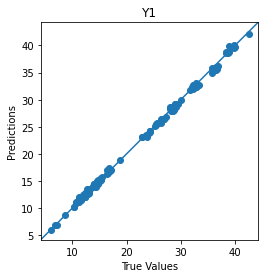

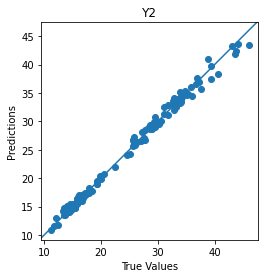

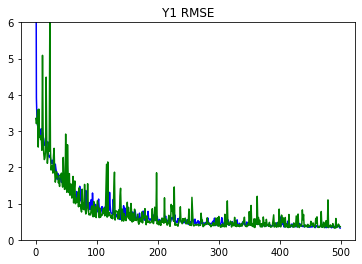

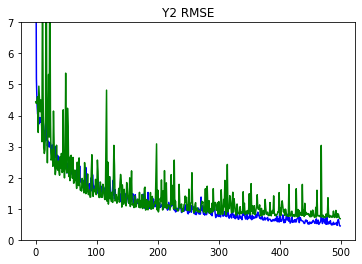

In [8]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)